In [1]:
print("✅ 라이브러리 로딩 시작...")
import joblib
import pandas as pd
import numpy as np
import time
import os
import warnings
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
print("✅ 라이브러리 로딩 완료!")

# =======================================================
# 🧹 1단계: 정제된 데이터 로딩
# =======================================================
print("\n" + "="*80)
print("🧹 1단계: 정제된 데이터 로딩")
print("="*80)
print("📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...")
try:
    flow_data = joblib.load("task2_data/train_flow_data_cleaned.pkl")
    all_packets = joblib.load("task2_data/train_packet_data_cleaned.pkl")
    print(f"✅ 정제된 Flow 데이터 ({len(flow_data):,}개) 로딩 완료")
    print(f"✅ 정제된 Packet 데이터 ({len(all_packets):,}개) 로딩 완료")
except FileNotFoundError:
    print("❌ 정제된 파일을 찾을 수 없습니다!")
    print("   먼저 이전 파이프라인의 '데이터 정제' 부분을 실행하여 _cleaned.pkl 파일을 생성해주세요.")
    exit()

✅ 라이브러리 로딩 시작...
✅ 라이브러리 로딩 완료!

🧹 1단계: 정제된 데이터 로딩
📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...
✅ 라이브러리 로딩 완료!

🧹 1단계: 정제된 데이터 로딩
📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...
✅ 정제된 Flow 데이터 (381,559개) 로딩 완료
✅ 정제된 Packet 데이터 (381,559개) 로딩 완료
✅ 정제된 Flow 데이터 (381,559개) 로딩 완료
✅ 정제된 Packet 데이터 (381,559개) 로딩 완료


In [2]:
# =======================================================
# 🎯 2단계: 대표 샘플 생성
# =======================================================
print("\n" + "="*80)
print("🎯 2단계: 대표 샘플 생성 (층화 추출)")
print("="*80)
# 👈 새로운 특징 추출은 계산 비용이 높으므로, 먼저 5만개로 빠르게 테스트합니다.
target_total_samples = 50000  
print(f"🎯 목표 총 샘플 수: {target_total_samples:,}개")
stratify_key = flow_data['duration_class'].astype(str) # 이제 duration 기준으로 층화
stratified_sampler = StratifiedShuffleSplit(n_splits=1, train_size=target_total_samples, random_state=42)
indices = np.arange(len(flow_data))
sampled_indices, _ = next(stratified_sampler.split(indices, stratify_key))
print(f"✅ 샘플링 완료! 총 {len(sampled_indices):,}개 대표 샘플 인덱스 확보.")


🎯 2단계: 대표 샘플 생성 (층화 추출)
🎯 목표 총 샘플 수: 50,000개
✅ 샘플링 완료! 총 50,000개 대표 샘플 인덱스 확보.
✅ 샘플링 완료! 총 50,000개 대표 샘플 인덱스 확보.


In [3]:
def extract_packet_features(packets, n=3):
    features = {}
    num_packets = min(n, len(packets))
    if num_packets == 0:
        return features
    packets = packets.iloc[:num_packets]
    
    numeric_cols = packets.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        features[f'first_{col}'] = packets.iloc[0][col] if col in packets.columns else 0
        features[f'second_{col}'] = packets.iloc[1][col] if col in packets.columns and num_packets > 1 else 0
    
    if 'ip_len' in packets.columns:
        ip_lens = packets['ip_len'].values
        features['ip_len_mean_13'] = np.mean(ip_lens)
        features['ip_len_std_13'] = np.std(ip_lens) if len(ip_lens) > 1 else 0
        features['ip_len_max_13'] = np.max(ip_lens)
        features['ip_len_min_13'] = np.min(ip_lens)
        features['ip_len_range_13'] = np.max(ip_lens) - np.min(ip_lens)
        features['ip_len_median_13'] = np.median(ip_lens)
        if len(ip_lens) >= 2:
            diffs = np.diff(ip_lens)
            mean_diff = np.mean(diffs)
            features['ip_len_trend'] = 1 if mean_diff > 0 else (-1 if mean_diff < 0 else 0)
            features['ip_len_volatility'] = np.std(diffs) if len(diffs) > 1 else 0
        else:
            features['ip_len_trend'] = 0
            features['ip_len_volatility'] = 0

    if 'packet_capture_time' in packets.columns and num_packets > 1:
        try:
            times = pd.to_datetime(packets['packet_capture_time'])
            time_diffs = np.diff(times).astype('timedelta64[us]').astype(float)
            if len(time_diffs) > 0:
                features['inter_time_mean_13'] = np.mean(time_diffs)
                features['inter_time_std_13'] = np.std(time_diffs) if len(time_diffs) > 1 else 0
                features['inter_time_max_13'] = np.max(time_diffs)
                features['inter_time_min_13'] = np.min(time_diffs)
                mean_time = np.mean(time_diffs)
                features['timing_consistency'] = np.std(time_diffs) / (mean_time + 1e-6)
            else:
                for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
                    features[key] = 0
        except:
            for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
                features[key] = 0
    else:
        for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
            features[key] = 0

    if 'tcp_len' in packets.columns and 'ip_len' in packets.columns:
        tcp_lens = packets['tcp_len'].values
        features['tcp_len_mean_13'] = np.mean(tcp_lens)
        features['tcp_len_std_13'] = np.std(tcp_lens) if len(tcp_lens) > 1 else 0
        features['tcp_len_sum_13'] = np.sum(tcp_lens)
        total_ip = np.sum(packets['ip_len'])
        total_tcp = np.sum(tcp_lens)
        features['tcp_efficiency_13'] = total_tcp / max(total_ip, 1)

    if 'tcp_flags' in packets.columns:
        flags = packets['tcp_flags'].values
        features['has_syn'] = int(any(flag & 0x02 for flag in flags))
        features['has_ack'] = int(any(flag & 0x10 for flag in flags))
        features['has_fin'] = int(any(flag & 0x01 for flag in flags))
        features['has_rst'] = int(any(flag & 0x04 for flag in flags))
        features['has_psh'] = int(any(flag & 0x08 for flag in flags))
        if len(flags) >= 3:
            first_syn = (flags[0] & 0x02) != 0
            second_syn_ack = (flags[1] & 0x12) == 0x12
            third_ack = (flags[2] & 0x10) != 0
            features['is_handshake_complete'] = int(first_syn and second_syn_ack and third_ack)
            has_fin_ack = any((flag & 0x11) == 0x11 for flag in flags)
            features['is_graceful_close'] = int(has_fin_ack)
        else:
            features['is_handshake_complete'] = 0
            features['is_graceful_close'] = 0
        features['flag_diversity'] = len(set(flags))
        features['push_frequency'] = sum(1 for flag in flags if flag & 0x08) / len(flags) if len(flags) > 0 else 0
    else:
        features['has_syn'] = 0
        features['has_ack'] = 0
        features['has_fin'] = 0
        features['has_rst'] = 0
        features['has_psh'] = 0
        features['is_handshake_complete'] = 0
        features['is_graceful_close'] = 0
        features['flag_diversity'] = 0
        features['push_frequency'] = 0

    if 'ip_len' in packets.columns and num_packets >= 3:
        sizes = packets['ip_len'].values
        increases = sum(1 for i in range(1, len(sizes)) if sizes[i] > sizes[i-1])
        decreases = sum(1 for i in range(1, len(sizes)) if sizes[i] < sizes[i-1])
        stability = sum(1 for i in range(1, len(sizes)) if sizes[i] == sizes[i-1])
        features['size_increase_count'] = increases
        features['size_decrease_count'] = decreases
        features['size_stability'] = stability
    else:
        features['size_increase_count'] = 0
        features['size_decrease_count'] = 0
        features['size_stability'] = 0

    if 'tcp_len' in packets.columns and 'ip_len' in packets.columns:
        features['tcp_to_ip_ratio_first'] = packets.iloc[0]['tcp_len'] / max(packets.iloc[0]['ip_len'], 1)
        if num_packets > 1:
            features['tcp_to_ip_ratio_second'] = packets.iloc[1]['tcp_len'] / max(packets.iloc[1]['ip_len'], 1)
        else:
            features['tcp_to_ip_ratio_second'] = 0
    else:
        features['tcp_to_ip_ratio_first'] = 0
        features['tcp_to_ip_ratio_second'] = 0

    features['inter_packet_time_us'] = features.get('inter_time_mean_13', 0)
    features['ip_len_diff'] = features.get('second_ip_len', 0) - features.get('first_ip_len', 0)

    return features


def extract_advanced_features_from_cleaned_data(indices, packet_data_list, n=3):
    print("🚀 고급 특징 추출 시작 (샘플링 데이터)...")
    features_list = []
    for i, idx in enumerate(indices):
        try:
            packet_df = packet_data_list[idx]
            if isinstance(packet_df, pd.DataFrame) and not packet_df.empty:
                valid_packets = packet_df.dropna()
                if len(valid_packets) >= 1:
                    features = extract_packet_features(valid_packets, n)
                    features_list.append(features)
                else:
                    features_list.append({})
            else:
                features_list.append({})
            if (i + 1) % 10000 == 0:
                print(f"     진행률: {i + 1:,} / {len(indices):,}개 완료")
        except Exception:
            features_list.append({})
    return features_list


advanced_features_list = extract_advanced_features_from_cleaned_data(sampled_indices, all_packets)
advanced_features_df = pd.DataFrame(advanced_features_list).fillna(0)
valid_flow_data = flow_data.iloc[sampled_indices].reset_index(drop=True)
print(f"\n✅ 특징 추출 완료! (샘플링 데이터)")
print(f"✓ 최종 특징 행렬 크기: {advanced_features_df.shape}")
print(f"✓ 최종 타겟 데이터 크기: {valid_flow_data.shape}")

🚀 고급 특징 추출 시작 (샘플링 데이터)...
     진행률: 10,000 / 50,000개 완료
     진행률: 10,000 / 50,000개 완료
     진행률: 20,000 / 50,000개 완료
     진행률: 20,000 / 50,000개 완료
     진행률: 30,000 / 50,000개 완료
     진행률: 30,000 / 50,000개 완료
     진행률: 40,000 / 50,000개 완료
     진행률: 40,000 / 50,000개 완료
     진행률: 50,000 / 50,000개 완료
     진행률: 50,000 / 50,000개 완료

✅ 특징 추출 완료! (샘플링 데이터)
✓ 최종 특징 행렬 크기: (50000, 53)
✓ 최종 타겟 데이터 크기: (50000, 11)

✅ 특징 추출 완료! (샘플링 데이터)
✓ 최종 특징 행렬 크기: (50000, 53)
✓ 최종 타겟 데이터 크기: (50000, 11)


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X = advanced_features_df
y = valid_flow_data['duration_class']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\n📊 데이터 준비: 학습 {X_train.shape[0]:,}개 | 검증 {X_test.shape[0]:,}개 | 특징 {X_train.shape[1]:,}개")

# 클래스 가중치 계산
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = {int(cls): weight for cls, weight in zip(classes, weights)}
print("📌 클래스 가중치:", class_weights_dict)

# -------------------------
# 1. XGBoost
# -------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=None,  # 다중클래스에서는 클래스 가중치를 sample_weight로
    tree_method='hist'
)
xgb_model.fit(X_train, y_train, sample_weight=y_train.map(class_weights_dict))

xgb_pred = xgb_model.predict(X_test)
print("\n===== 📊 XGBoost 성능 =====")
print("정확도:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred, digits=4))

# -------------------------
# 2. LightGBM
# -------------------------
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=12,
    learning_rate=0.03,
    num_leaves=200,
    random_state=42,
    class_weight=class_weights_dict
)
lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_test)
print("\n===== 📊 LightGBM 성능 =====")
print("정확도:", accuracy_score(y_test, lgb_pred))
print(classification_report(y_test, lgb_pred, digits=4))

# -------------------------
# 3. RandomForest
# -------------------------
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight=class_weights_dict,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
print("\n===== 📊 RandomForest 성능 =====")
print("정확도:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, digits=4))



📊 데이터 준비: 학습 40,000개 | 검증 10,000개 | 특징 53개
📌 클래스 가중치: {0: np.float64(6.389776357827476), 1: np.float64(0.7052186177715092), 2: np.float64(1.0657572205051689), 3: np.float64(0.6724045185583647)}

===== 📊 XGBoost 성능 =====
정확도: 0.7418
              precision    recall  f1-score   support

           0     0.9656    0.9335    0.9493       391
           1     0.7631    0.8039    0.7830      3545
           2     0.5853    0.6726    0.6259      2346
           3     0.8226    0.7060    0.7599      3718

    accuracy                         0.7418     10000
   macro avg     0.7841    0.7790    0.7795     10000
weighted avg     0.7514    0.7418    0.7440     10000


===== 📊 XGBoost 성능 =====
정확도: 0.7418
              precision    recall  f1-score   support

           0     0.9656    0.9335    0.9493       391
           1     0.7631    0.8039    0.7830      3545
           2     0.5853    0.6726    0.6259      2346
           3     0.8226    0.7060    0.7599      3718

    accuracy          

In [5]:
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

def print_and_return_report(y_true, y_pred, model_name):
    print(f"\n===== 📊 {model_name} 성능 =====")
    print("정확도:", accuracy_score(y_true, y_pred))
    report_dict = classification_report(y_true, y_pred, output_dict=True, digits=4)
    print(classification_report(y_true, y_pred, digits=4))
    return pd.DataFrame(report_dict).T

# 1. XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=None,
    tree_method='hist'
)
xgb_model.fit(X_train, y_train, sample_weight=y_train.map(class_weights_dict))
xgb_pred = xgb_model.predict(X_test)

# 2. LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=12,
    learning_rate=0.03,
    num_leaves=200,
    random_state=42,
    class_weight=class_weights_dict
)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# 3. RandomForest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight=class_weights_dict,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 4. CatBoost
cat_model = CatBoostClassifier(
    iterations=600,
    depth=10,
    learning_rate=0.03,
    l2_leaf_reg=3,
    border_count=128,
    random_seed=42,
    verbose=False,
    class_weights=[class_weights_dict.get(i,1) for i in sorted(class_weights_dict.keys())]
)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

# 5. ExtraTreesClassifier
et_model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    class_weight=class_weights_dict,
    n_jobs=-1
)
et_model.fit(X_train, y_train)
et_pred = et_model.predict(X_test)

# 성능 출력
xgb_report_df = print_and_return_report(y_test, xgb_pred, "XGBoost")
lgb_report_df = print_and_return_report(y_test, lgb_pred, "LightGBM")
rf_report_df = print_and_return_report(y_test, rf_pred, "RandomForest")
cat_report_df = print_and_return_report(y_test, cat_pred, "CatBoost")
et_report_df = print_and_return_report(y_test, et_pred, "ExtraTrees")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7980
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 40
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

1. 모델 선택: 누구를 모으고, 누구를 버릴까?
앙상블의 핵심은 '전반적으로 강하면서도 서로의 약점을 보완해줄 수 있는' 모델들을 조합하는 것입니다.

✅ 포함할 모델 (Keep)

XGBoost: 전체 성능이 가장 뛰어나고, 가장 취약한 '클래스 2'에서도 가장 좋은 F1-Score를 기록했습니다. 앙상블의 중심 역할을 할 필수 모델입니다.

RandomForest: 소수 클래스인 '클래스 0'에서 가장 뛰어난 성능을 보였습니다. XGBoost가 놓칠 수 있는 부분을 보완해줄 수 있는 중요한 모델입니다.

ExtraTrees: 전체 성능은 중간이지만, '클래스 2'에서 XGBoost 다음으로 좋은 성능을 보여주었습니다. RandomForest와는 다른 방식으로 동작하는 모델이므로, 앙상블의 예측 다양성을 높여줄 수 있습니다.

❌ 제외할 모델 (Discard)

LightGBM: XGBoost와 같은 부스팅 계열이면서 전반적으로 성능이 약간 낮습니다. 예측 패턴이 유사할 가능성이 높아 앙상블에 추가했을 때 큰 성능 향상을 기대하기 어렵습니다.

CatBoost: 이번 평가에서 전반적인 성능이 가장 낮았습니다. 특별히 다른 모델에 비해 뚜렷한 강점을 보이지 못했으므로 제외하는 것이 합리적입니다.

따라서 XGBoost, RandomForest, ExtraTrees 세 가지 모델로 앙상블을 구성하는 것이 가장 좋은 선택입니다.

2. 앙상블 방법: Soft Voting
이번에도 각 모델의 예측 확률까지 고려하는 소프트 보팅 (Soft Voting) 방식을 추천합니다. 모델들이 특정 클래스를 얼마나 확신하는지에 대한 정보를 활용함으로써, 단순히 투표만 하는 하드 보팅보다 더 정교하고 안정적인 예측을 할 수 있습니다.

3. 모델별 가중치: 어떻게 설정할까?
소프트 보팅의 성능은 각 모델에 부여하는 가중치에 따라 달라질 수 있습니다. 다음과 같은 두 가지 접근법을 제안합니다.

1안: 성능 기반 가중치 (가장 안정적인 선택)
가장 직관적이고 안정적인 방법은 검증된 성능 지표인 **정확도(Accuracy)**에 비례하여 가중치를 부여하는 것입니다.

XGBoost (0.7418), RandomForest (0.7338), ExtraTrees (0.7317)

이 점수들의 비율을 고려하여 단순하게 3 : 2 : 2 와 같은 정수 비율로 가중치를 설정하여 시작해볼 수 있습니다. 이는 가장 성능이 좋은 XGBoost에 약간 더 높은 영향력을 주는 방식입니다.

2안: 약점 보완 가중치 (고급 전략)
만약 '클래스 2'의 성능을 개선하는 것이 최우선 과제라면, 해당 클래스에서 좋은 성능을 보인 모델에 가중치를 더 부여하는 전략을 시도해볼 수 있습니다.

'클래스 2' F1-Score: XGBoost (0.6259), ExtraTrees (0.6205), RandomForest (0.6097)

이 경우 XGBoost와 ExtraTrees에 더 높은 가중치를 주는 것을 고려할 수 있습니다. 예를 들어 3 : 1 : 2 와 같이 조정하여 클래스 2에 대한 예측력을 강화하는 방향을 테스트해볼 수 있습니다.

In [21]:
X = advanced_features_df
y_duration = valid_flow_data['duration_class']
y_volume = valid_flow_data['volume_class']
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import joblib

# 데이터 분할
X_train, X_test, y_duration_train, y_duration_test = train_test_split(X, y_duration, test_size=0.2, random_state=42, stratify=y_duration)
_, _, y_volume_train, y_volume_test = train_test_split(X, y_volume, test_size=0.2, random_state=42, stratify=y_volume)
print(f"\n📊 데이터 준비: 학습 {X_train.shape[0]:,}개 | 검증 {X_test.shape[0]:,}개 | 특징 {X_train.shape[1]:,}개")

# 클래스 가중치 계산
duration_classes = np.unique(y_duration_train)
duration_weights = compute_class_weight('balanced', classes=duration_classes, y=y_duration_train)
duration_class_weights = {int(cls): weight for cls, weight in zip(duration_classes, duration_weights)}

# LightGBM 모델 학습 (가중치 적용)
lgb_best_params = {
    'n_estimators': 200,
    'max_depth': 12,
    'learning_rate': 0.03,
    'num_leaves': 200,
    'device': 'cpu',
    'verbose': -1,
    'force_row_wise': False,
    'random_state': 42,
    'class_weight': duration_class_weights
}

lgb_duration = lgb.LGBMClassifier(**lgb_best_params)
lgb_duration.fit(X_train, y_duration_train)

# 모델 저장
joblib.dump(lgb_duration, 'model/lgb_duration_model_0809.pkl')
print('✅ LightGBM Duration 모델 저장 완료: model/lgb_duration_model_0809.pkl')


📊 데이터 준비: 학습 40,000개 | 검증 10,000개 | 특징 53개
✅ LightGBM Duration 모델 저장 완료: model/lgb_duration_model_0809.pkl
✅ LightGBM Duration 모델 저장 완료: model/lgb_duration_model_0809.pkl


✅ 라이브러리 로딩 시작...
✅ 라이브러리 로딩 완료!

🧹 1단계: 정제된 데이터 로딩
📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...
✅ 정제된 Flow 데이터 (381,559개) 로딩 완료
✅ 정제된 Packet 데이터 (381,559개) 로딩 완료

🎯 2단계: 대표 샘플 생성 (층화 추출)
🎯 목표 총 샘플 수: 50,000개
✅ 정제된 Flow 데이터 (381,559개) 로딩 완료
✅ 정제된 Packet 데이터 (381,559개) 로딩 완료

🎯 2단계: 대표 샘플 생성 (층화 추출)
🎯 목표 총 샘플 수: 50,000개
✅ 샘플링 완료! 총 50,000개 대표 샘플 인덱스 확보.

🔧 3단계: 특징 추출 함수 정의 (가변 처리 로직 강조)
✅ 특징 추출 함수 준비 완료! (가변 패킷 처리 로직 포함)

🔬 4단계: 최종 데이터 준비 (최대 N=3)
🚀 최대 N=3 값을 기준으로 특징 추출 중...
✅ 샘플링 완료! 총 50,000개 대표 샘플 인덱스 확보.

🔧 3단계: 특징 추출 함수 정의 (가변 처리 로직 강조)
✅ 특징 추출 함수 준비 완료! (가변 패킷 처리 로직 포함)

🔬 4단계: 최종 데이터 준비 (최대 N=3)
🚀 최대 N=3 값을 기준으로 특징 추출 중...
✅ 특징 추출 완료! (소요 시간: 52.70초, 최종 샘플 수: 50,000개)
📊 데이터 분할 완료: 학습 40,000개 | 검증 10,000개

⏳ 클래스 가중치를 계산합니다...
✅ 계산된 가중치(dict): {0: np.float64(0.7290755322251385), 1: np.float64(1.031140441328109), 2: np.float64(0.7028394714647175), 3: np.float64(4.2408821034775235)}
✅ XGBoost용 sample_weight 배열 생성 완료

🏆 5단계: 챔피언 모델 정의 및 최종 평가
✅ 5개의 챔피언 모델이 최적의 하이퍼파라미터로 준비되었습니다.

----- 🧪 Random

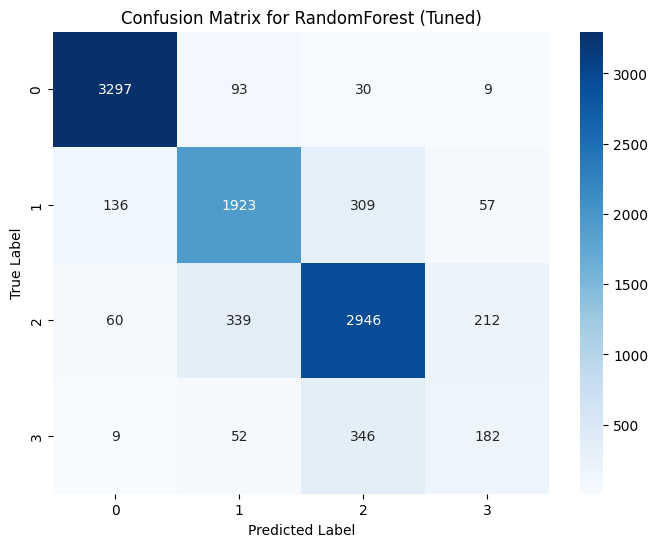


----- 🧪 ExtraTrees 모델 최종 평가 시작 -----
하이퍼파라미터: {'n_estimators': 703, 'max_depth': 34}
✅ 학습 및 예측 완료! (소요 시간: 3.57초)

--- 최종 성능 (최대 N=3) ---
Micro F1 Score: 0.8250
페널티: -0.1
🏆 최종 조정 점수: 0.7250
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3429
           1       0.79      0.78      0.78      2425
           2       0.81      0.81      0.81      3557
           3       0.38      0.34      0.36       589

    accuracy                           0.82     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.82      0.82      0.82     10000

✅ 학습 및 예측 완료! (소요 시간: 3.57초)

--- 최종 성능 (최대 N=3) ---
Micro F1 Score: 0.8250
페널티: -0.1
🏆 최종 조정 점수: 0.7250
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3429
           1       0.79      0.78      0.78      2425
  

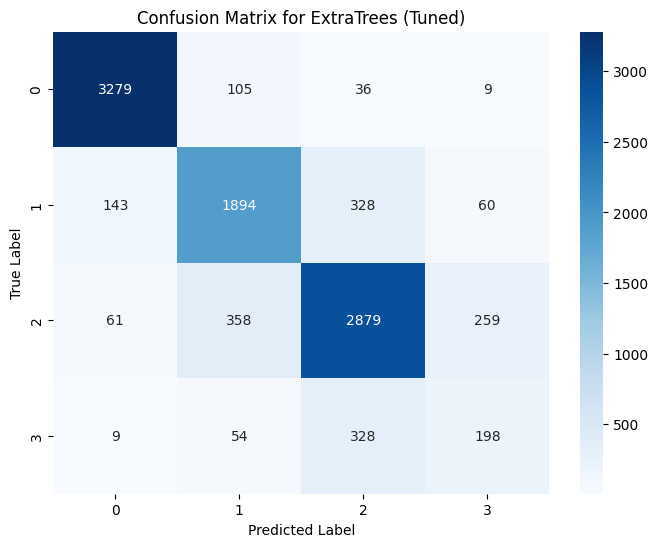


----- 🧪 LightGBM 모델 최종 평가 시작 -----
하이퍼파라미터: {'n_estimators': 843, 'learning_rate': 0.1477594092687316}
✅ 학습 및 예측 완료! (소요 시간: 4.19초)

--- 최종 성능 (최대 N=3) ---
Micro F1 Score: 0.8218
페널티: -0.1
🏆 최종 조정 점수: 0.7218
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3429
           1       0.79      0.80      0.79      2425
           2       0.82      0.78      0.80      3557
           3       0.35      0.42      0.38       589

    accuracy                           0.82     10000
   macro avg       0.72      0.74      0.73     10000
weighted avg       0.83      0.82      0.82     10000

✅ 학습 및 예측 완료! (소요 시간: 4.19초)

--- 최종 성능 (최대 N=3) ---
Micro F1 Score: 0.8218
페널티: -0.1
🏆 최종 조정 점수: 0.7218
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3429
           1       0.79      0.80     

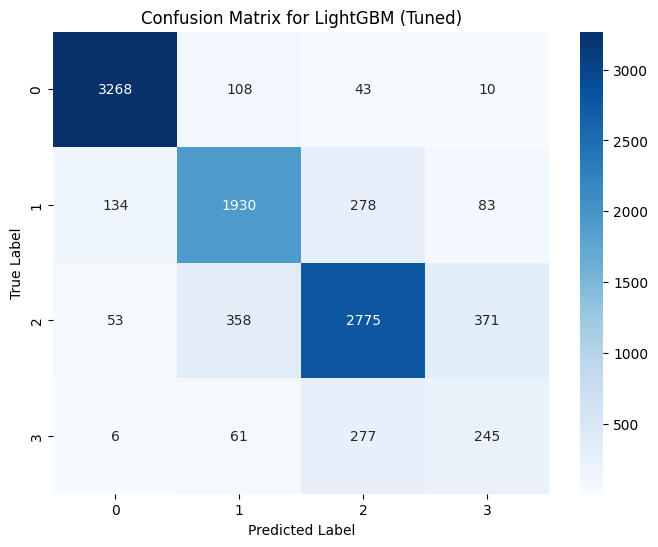


----- 🧪 XGBoost 모델 최종 평가 시작 -----
하이퍼파라미터: {'n_estimators': 560, 'learning_rate': 0.11294687124112764, 'max_depth': 10}
✅ 학습 및 예측 완료! (소요 시간: 5.37초)

--- 최종 성능 (최대 N=3) ---
Micro F1 Score: 0.8200
페널티: -0.1
🏆 최종 조정 점수: 0.7200
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3429
           1       0.78      0.79      0.78      2425
           2       0.82      0.78      0.80      3557
           3       0.34      0.38      0.36       589

    accuracy                           0.82     10000
   macro avg       0.72      0.73      0.72     10000
weighted avg       0.82      0.82      0.82     10000

✅ 학습 및 예측 완료! (소요 시간: 5.37초)

--- 최종 성능 (최대 N=3) ---
Micro F1 Score: 0.8200
페널티: -0.1
🏆 최종 조정 점수: 0.7200
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3429
           1       0.

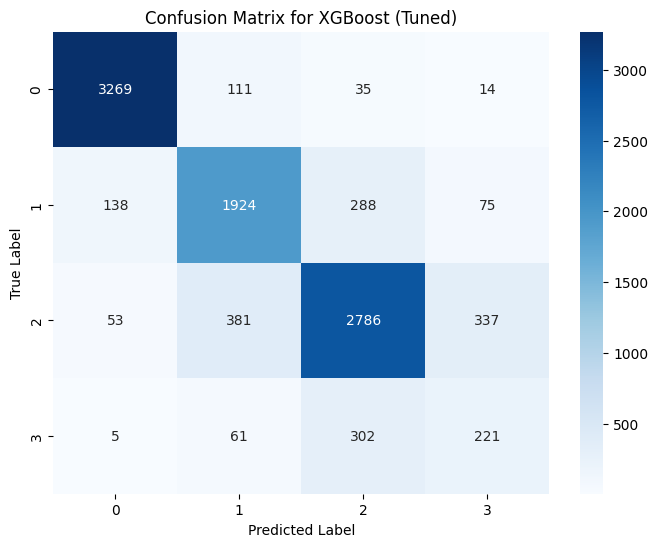


----- 🧪 CatBoost 모델 최종 평가 시작 -----
하이퍼파라미터: {'iterations': 839, 'learning_rate': 0.1762109604779554, 'depth': 10}
✅ 학습 및 예측 완료! (소요 시간: 64.58초)

--- 최종 성능 (최대 N=3) ---
Micro F1 Score: 0.8107
페널티: -0.1
🏆 최종 조정 점수: 0.7107
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3429
           1       0.78      0.80      0.79      2425
           2       0.84      0.74      0.78      3557
           3       0.31      0.46      0.37       589

    accuracy                           0.81     10000
   macro avg       0.71      0.74      0.72     10000
weighted avg       0.83      0.81      0.82     10000

✅ 학습 및 예측 완료! (소요 시간: 64.58초)

--- 최종 성능 (최대 N=3) ---
Micro F1 Score: 0.8107
페널티: -0.1
🏆 최종 조정 점수: 0.7107
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3429
           1       0.78  

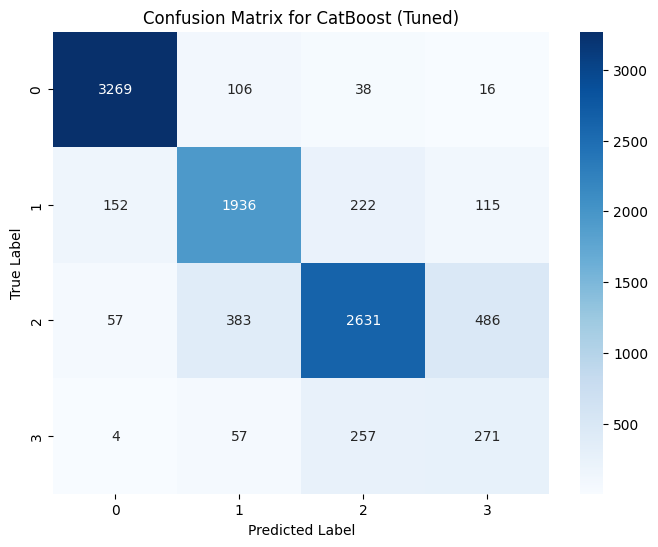


🎉 7단계: 최종 결과 종합 비교
          Model  Final Score  Micro F1
0  RandomForest       0.7348    0.8348
1    ExtraTrees       0.7250    0.8250
2      LightGBM       0.7218    0.8218
3       XGBoost       0.7200    0.8200
4      CatBoost       0.7107    0.8107

✨ 최종 결론: [RandomForest] 모델이 최종 점수 0.7348로 가장 좋은 성능을 보였습니다.


In [ ]:
# ======================================================================
# 🚀 "Volume" 과제 최종 평가 파이프라인 (가변 패킷 처리 명시)
# ======================================================================
print("✅ 라이브러리 로딩 시작...")
import joblib
import pandas as pd
import numpy as np
import time
import os
import warnings

# 모델 및 평가 관련 라이브러리
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
print("✅ 라이브러리 로딩 완료!")


# =======================================================
# 🧹 1단계: 정제된 데이터 로딩
# =======================================================
print("\n" + "="*80)
print("🧹 1단계: 정제된 데이터 로딩")
print("="*80)
print("📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...")
try:
    flow_data = joblib.load("task2_data/train_flow_data_cleaned.pkl")
    all_packets = joblib.load("task2_data/train_packet_data_cleaned.pkl")
    print(f"✅ 정제된 Flow 데이터 ({len(flow_data):,}개) 로딩 완료")
    print(f"✅ 정제된 Packet 데이터 ({len(all_packets):,}개) 로딩 완료")
except FileNotFoundError:
    print("❌ 정제된 파일을 찾을 수 없습니다!")
    print("   먼저 이전 파이프라인의 '데이터 정제' 부분을 실행하여 _cleaned.pkl 파일을 생성해주세요.")
    # exit() # 실제 실행 시에는 주석 해제


# =======================================================
# 🎯 2단계: 대표 샘플 생성 (층화 추출)
# =======================================================
print("\n" + "="*80)
print("🎯 2단계: 대표 샘플 생성 (층화 추출)")
print("="*80)
target_total_samples = 50000  
print(f"🎯 목표 총 샘플 수: {target_total_samples:,}개")
stratify_key = flow_data['volume_class'].astype(str)
stratified_sampler = StratifiedShuffleSplit(n_splits=1, train_size=target_total_samples, random_state=42)
indices = np.arange(len(flow_data))
sampled_indices, _ = next(stratified_sampler.split(indices, stratify_key))
print(f"✅ 샘플링 완료! 총 {len(sampled_indices):,}개 대표 샘플 인덱스 확보.")


# =======================================================
# 🔧 3단계: 특징 추출 함수 정의 (가변 처리 로직 강조)
# =======================================================
print("\n" + "="*80)
print("🔧 3단계: 특징 추출 함수 정의 (가변 처리 로직 강조)")
print("="*80)

def extract_features_for_n_packets(packets, n):
    """
    주어진 'n'을 최대치로 하여, 실제 사용 가능한 패킷만으로 특징을 추출합니다.
    """
    num_packets_available = len(packets)
    if num_packets_available == 0: return {}

    # ✨✨✨ 사용자 요청 핵심 로직 ✨✨✨
    # 사용할 패킷 수는 최대 n개와 실제 패킷 수 중 '더 작은 값'으로 결정됩니다.
    # 즉, 패킷이 1개만 있으면 1개만 사용하고, 2개 있으면 2개만 사용합니다.
    n_to_use = min(n, num_packets_available)
    packets = packets.iloc[:n_to_use]
    
    features = {}
    # (이하 특징 추출 로직은 이전과 동일)
    for col in ['ip_len', 'ip_hdr_len', 'tcp_len', 'tcp_hdr_len']:
        if col in packets.columns:
            values = packets[col].values
            features[f'{col}_mean_{n}'] = np.mean(values)
            features[f'{col}_std_{n}'] = np.std(values) if len(values) > 1 else 0
            features[f'{col}_sum_{n}'] = np.sum(values)
    if 'packet_capture_time' in packets.columns and len(packets) > 1:
        try:
            times = pd.to_datetime(packets['packet_capture_time'])
            time_diffs = np.diff(times).astype('timedelta64[us]').astype(float)
            if len(time_diffs) > 0:
                features[f'inter_time_mean_{n}'] = np.mean(time_diffs)
                features[f'inter_time_std_{n}'] = np.std(time_diffs) if len(time_diffs) > 1 else 0
        except Exception: pass
    if 'tcp_window_size' in packets.columns:
        features[f'initial_tcp_win_size'] = packets['tcp_window_size'].iloc[0]
        features[f'mean_tcp_win_size_{n}'] = packets['tcp_window_size'].mean()
    flag_cols = ['tcp_flags_ack', 'tcp_flags_push', 'tcp_flags_reset', 'tcp_flags_syn', 'tcp_flags_fin']
    for flag in flag_cols:
        if flag in packets.columns:
            features[f'{flag}_count_{n}'] = packets[flag].sum()
    for col in ['ip_tos', 'ip_ttl']:
        if col in packets.columns:
            values = packets[col].values
            features[f'{col}_mean_{n}'] = np.mean(values)
            features[f'first_{col}'] = values[0]
    if 'ip_len' in packets.columns and 'tcp_len' in packets.columns:
        total_ip_len = packets['ip_len'].sum()
        total_tcp_len = packets['tcp_len'].sum()
        features[f'payload_ratio_{n}'] = total_tcp_len / total_ip_len if total_ip_len > 0 else 0
    return features
print("✅ 특징 추출 함수 준비 완료! (가변 패킷 처리 로직 포함)")


# =======================================================
# 🔬 4단계: 최종 데이터 준비
# =======================================================
print("\n" + "="*80)
print("🔬 4단계: 최종 데이터 준비 (최대 N=3)")
print("="*80)

N_MAX = 3 # 이제 이 변수는 '최대' 패킷 수를 의미합니다.
print(f"🚀 최대 N={N_MAX} 값을 기준으로 특징 추출 중...")
start_time = time.time()
features_list = []
successful_indices = []

for i in range(len(sampled_indices)):
    original_idx = sampled_indices[i]
    try:
        packet_df = all_packets[original_idx]
        if isinstance(packet_df, pd.DataFrame) and not packet_df.empty:
            # 함수 내부에서 실제 패킷 수를 감지하여 처리하므로, N_MAX만 넘겨주면 됩니다.
            features = extract_features_for_n_packets(packet_df, n=N_MAX)
            if features:
                features_list.append(features)
                successful_indices.append(i)
    except Exception: continue

X = pd.DataFrame(features_list).fillna(0)
y = flow_data.iloc[sampled_indices].reset_index(drop=True).loc[successful_indices, 'volume_class']
print(f"✅ 특징 추출 완료! (소요 시간: {time.time() - start_time:.2f}초, 최종 샘플 수: {len(X):,}개)")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"📊 데이터 분할 완료: 학습 {len(X_train):,}개 | 검증 {len(X_test):,}개")

print("\n⏳ 클래스 가중치를 계산합니다...")
volume_classes = np.unique(y_train)
volume_weights_array = compute_class_weight(class_weight='balanced', classes=volume_classes, y=y_train)
volume_class_weights_dict = {int(cls): weight for cls, weight in zip(volume_classes, volume_weights_array)}
sample_weights = np.array([volume_class_weights_dict[i] for i in y_train])
print(f"✅ 계산된 가중치(dict): {volume_class_weights_dict}")
print("✅ XGBoost용 sample_weight 배열 생성 완료")


# =======================================================
# 🏆 5단계: "챔피언 모델" 정의 및 최종 평가 (이전과 동일)
# =======================================================
print("\n" + "="*80)
print("🏆 5단계: 챔피언 모델 정의 및 최종 평가")
print("="*80)

# 튜닝된 파라미터는 그대로 사용합니다.
champion_params = {
    'RandomForest': {'n_estimators': 855, 'max_depth': 22},
    'ExtraTrees': {'n_estimators': 703, 'max_depth': 34},
    'LightGBM': {'n_estimators': 843, 'learning_rate': 0.1477594092687316},
    'XGBoost': {'n_estimators': 560, 'learning_rate': 0.11294687124112764, 'max_depth': 10},
    'CatBoost': {'iterations': 839, 'learning_rate': 0.1762109604779554, 'depth': 10}
}
models_to_evaluate = {
    # (모델 정의 부분은 이전과 동일)
    "RandomForest": RandomForestClassifier(**champion_params['RandomForest'], class_weight=volume_class_weights_dict, random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesClassifier(**champion_params['ExtraTrees'], class_weight=volume_class_weights_dict, random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(**champion_params['LightGBM'], class_weight=volume_class_weights_dict, random_state=42, n_jobs=-1, verbose=-1),
    "XGBoost": xgb.XGBClassifier(**champion_params['XGBoost'], random_state=42, n_jobs=-1),
    "CatBoost": CatBoostClassifier(**champion_params['CatBoost'], class_weights=volume_class_weights_dict, random_state=42, verbose=0, thread_count=-1)
}
print("✅ 5개의 챔피언 모델이 최적의 하이퍼파라미터로 준비되었습니다.")

# =======================================================
# 📊 6단계: 모델별 최종 성능 평가 실행 (이전과 동일)
# =======================================================
final_results = []
penalty = (N_MAX - 2) * 0.1 # 페널티는 N_MAX 기준으로 계산

for model_name, model in models_to_evaluate.items():
    print("\n" + "="*80)
    print(f"----- 🧪 {model_name} 모델 최종 평가 시작 -----")
    print(f"하이퍼파라미터: {champion_params[model_name]}")
    
    start_time = time.time()
    if model_name == "XGBoost":
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    final_score = micro_f1 - penalty
    
    print(f"✅ 학습 및 예측 완료! (소요 시간: {end_time - start_time:.2f}초)")
    print(f"\n--- 최종 성능 (최대 N={N_MAX}) ---")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"페널티: -{penalty:.1f}")
    print(f"🏆 최종 조정 점수: {final_score:.4f}")
    print("--------------------")
    
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    final_results.append({"Model": model_name, "Final Score": final_score, "Micro F1": micro_f1})
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name} (Tuned)')
    plt.show()

# =======================================================
# 🎉 7단계: 최종 결과 종합 비교 (이전과 동일)
# =======================================================
print("\n" + "="*80)
print("🎉 7단계: 최종 결과 종합 비교")
print("="*80)
results_df = pd.DataFrame(final_results).sort_values(by="Final Score", ascending=False).reset_index(drop=True)
print(results_df.to_string())
best_model_name = results_df.iloc[0]['Model']
best_score = results_df.iloc[0]['Final Score']
print(f"\n✨ 최종 결론: [{best_model_name}] 모델이 최종 점수 {best_score:.4f}로 가장 좋은 성능을 보였습니다.")


In [ ]:
# =======================================================
# 💾 8단계: RandomForest 모델 저장 (사용자 지정 경로)
# =======================================================
import joblib
import os

print("\n" + "="*80)
print("💾 8단계: RandomForest 모델을 지정된 경로에 저장")
print("="*80)

# 1. 사용자가 지정한 폴더와 파일명 설정
model_save_dir = 'model'
model_filename = 'rf_volume_model_0809.pkl'

# 2. 폴더가 없으면 생성
os.makedirs(model_save_dir, exist_ok=True)
print(f"📂 저장 폴더 확인/생성: '{model_save_dir}'")

# 3. 전체 저장 경로 조합
model_save_path = os.path.join(model_save_dir, model_filename)

try:
    # 4. 저장할 모델 객체 가져오기 (RandomForest 모델 명시)
    # 이전 단계의 'models_to_evaluate' 딕셔셔너리에서 RandomForest 모델을 직접 선택합니다.
    model_to_save = models_to_evaluate['RandomForest']
    print(f"🎯 저장할 모델: RandomForestClassifier")

    # 5. joblib을 사용하여 모델 저장
    joblib.dump(model_to_save, model_save_path)

    print(f"\n✅ 모델 저장이 완료되었습니다!")
    print(f"   - 저장 경로: {model_save_path}")

except NameError:
    print("❌ 오류: 'models_to_evaluate' 딕셔너리를 찾을 수 없습니다.")
    print("   이전 셀의 모델 평가 코드를 먼저 실행해주세요.")
except KeyError:
    print("❌ 오류: 'models_to_evaluate' 딕셔너리에 'RandomForest' 모델이 없습니다.")
    print("   모델 목록을 확인해주세요.")



💾 8단계: RandomForest 모델을 지정된 경로에 저장
📂 저장 폴더 확인/생성: 'model'
🎯 저장할 모델: RandomForestClassifier

✅ 모델 저장이 완료되었습니다!
   - 저장 경로: model\rf_volume_model_0809.pkl

✅ 모델 저장이 완료되었습니다!
   - 저장 경로: model\rf_volume_model_0809.pkl


✅ 포함할 모델 (Keep)

RandomForest: 전체 성능이 가장 우수하므로 앙상블의 중심을 잡아줄 핵심 모델입니다. 반드시 포함해야 합니다.

LightGBM: 가장 취약한 '클래스 3'에서 F1-Score가 가장 높습니다. 약점을 보완해줄 수 있는 중요한 모델입니다.

CatBoost: 학습 속도는 매우 느리지만, 클래스 3에 대한 재현율(Recall)이 독보적으로 높습니다. 이는 다른 모델들과 다른 방식으로 예측하고 있다는 증거이므로, 앙상블에 새로운 관점(다양성)을 더해 성능 향상에 기여할 가능성이 높습니다.

❌ 제외할 모델 (Discard)

ExtraTrees: RandomForest와 같은 배깅(Bagging) 계열이면서 전반적인 성능이 소폭 낮습니다. RandomForest와 예측 결과가 매우 유사할 가능성이 높아 앙상블의 다양성에 크게 기여하기 어렵습니다.

XGBoost: LightGBM과 같은 부스팅(Boosting) 계열이지만, 이번 평가에서는 LightGBM보다 약점 보완 능력이 다소 부족했습니다. LightGBM이 더 나은 대안이므로 제외합니다.

2. 앙상블 방법: Soft Voting
구체적인 앙상블 방법으로는 **소프트 보팅 (Soft Voting)**을 추천합니다.

작동 방식: 각 모델이 예측한 클래스별 '확률'을 가중 평균한 후, 가장 높은 확률을 가진 클래스를 최종 예측값으로 선택합니다.

왜 좋은가?: 단순히 다수결로 정하는 하드 보팅(Hard Voting)과 달리, "이 예측에 대해 80% 확신해" 와 같이 모델의 확신 수준까지 반영할 수 있어 일반적으로 더 성능이 좋습니다.

3. 모델별 가중치: 어떻게 설정할까?
소프트 보팅에서 각 모델의 영향력을 조절하는 가중치는 성능에 기반하여 설정하는 것이 논리적입니다.

1안: 성능 기반 가중치 (추천)
최종 조정 점수를 기준으로 가중치를 부여합니다. 이는 데이터로 증명된 성능을 직접적으로 반영하는 방법입니다.

RandomForest (0.7348), LightGBM (0.7218), CatBoost (0.7107)

이 점수들의 비율을 단순화하면 대략 3 : 2 : 1 또는 정규화하여 0.34 : 0.33 : 0.33 과 같이 설정할 수 있습니다.

python
# 예시: scikit-learn의 VotingClassifier 설정
# weights = [0.7348, 0.7218, 0.7107]
2안: 약점 보완 가중치 (시도해볼 만한 전략)
만약 클래스 3의 성능 개선이 최우선 목표라면, 해당 클래스에서 좋은 성능을 보인 모델에 더 높은 가중치를 부여할 수 있습니다.

LightGBM과 CatBoost의 가중치를 상대적으로 높여주는 방식입니다. 예를 들어 2 : 3 : 2 와 같이 조정해볼 수 있습니다.